In [ ]:
!pip install --quiet radgraph wikipedia

import torch, torch.nn as nn, torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel
from datasets import load_dataset
from torchvision import transforms
import timm
import numpy as np, matplotlib.pyplot as plt
from radgraph import RadGraph
import wikipedia
from tqdm import tqdm
from sklearn.metrics import roc_auc_score, roc_curve, auc

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on:", device, "| GPU:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.0/588.0 kB 13.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
Running on: cuda | GPU: Tesla T4


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
ds = load_dataset("itsanmolgupta/mimic-cxr-dataset")["train"]
print(len(ds))

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/357 [00:00<?, ?B/s]

data/train-00000-of-00002.parquet:   0%|          | 0.00/396M [00:00<?, ?B/s]

data/train-00001-of-00002.parquet:   0%|          | 0.00/397M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/30633 [00:00<?, ? examples/s]

30633


In [ ]:
N_train, N_test = 10000, 2000
train_ds = ds.select(range(N_train))
test_ds = ds.select(range(N_train, N_train + N_test))
print(len(ds))
print(len(train_ds))
print(len(test_ds))

30633
10000
2000


In [ ]:
rg = RadGraph(model="modern-radgraph-xl")

import re
def negation_rule(text, entity):
    window = text.lower()
    if re.search(rf"(no |without |absent |rule out ){entity}", window):
        return 0
    return 1

def extract_triplets(text):
    ann = rg([text])[0]
    triplets = []
    for e in ann["entities"].values():
        label = e["label"]
        tokens = e["tokens"].lower()
        if "observation" in label.lower():
            exist = 1 if "present" in label.lower() else (0 if "absent" in label.lower() else -1)
            exist = negation_rule(text, tokens)
            triplets.append({"entity": tokens, "exist": exist})
    return triplets

Using device: cuda:0
model_type not provided, defaulting to radgraph-xl


radgraph-xl.tar.gz:   0%|          | 0.00/416M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/radgraph/radgraph.py:105: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(path=model_dir)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


tokenizer_config.json:   0%|          | 0.00/228 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/473 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

In [ ]:
# CELL 5: entity KB enrichment (curated + wiki fallback)
entity_kb = {
    "pneumothorax": "Pneumothorax is the presence of air in the pleural space...",
    "cardiomegaly": "Cardiomegaly refers to an enlarged cardiac silhouette on chest radiograph..."
}
def get_entity_description(ent):
    e = ent.lower().strip()
    if e in entity_kb:
        return entity_kb[e]
    try:
        return wikipedia.summary(e, sentences=2)
    except Exception:
        return f"{ent} (radiographic finding)."

# test
print(get_entity_description("pneumonia"))


Pneumonia is an inflammatory condition of the lung primarily affecting the small air sacs known as alveoli. Symptoms typically include some combination of productive or dry cough, chest pain, fever, and difficulty breathing.


In [ ]:
tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
text_encoder = AutoModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT").to(device)
proj_text = nn.Linear(768, 768).to(device)

def embed_text(texts):
    enc = tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=64).to(device)
    with torch.no_grad():
        out = text_encoder(**enc)
    pooled = out.last_hidden_state.mean(1)
    return proj_text(pooled)

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

In [ ]:
backbone = timm.create_model("resnet50", pretrained=True, features_only=True).to(device)
img_tfm = transforms.Compose([
    transforms.Resize((512,512)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])
img_proj = nn.Linear(backbone.feature_info[-1]["num_chs"], 768).to(device)

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

In [ ]:
class Fusion(nn.Module):
    def __init__(self, d_model=768, nhead=8):
        super().__init__()
        dec_layer = nn.TransformerDecoderLayer(d_model, nhead, batch_first=True)
        self.decoder = nn.TransformerDecoder(dec_layer, num_layers=2)
        self.exist_head = nn.Linear(d_model, 1)
    def forward(self, V, Q):
        out = self.decoder(Q, V)         # (B,Qn,D)
        exist = self.exist_head(out).squeeze(-1)
        attn = torch.einsum("bqd,bnd->bqn", out, V).softmax(-1)
        return exist, attn

fusion = Fusion().to(device)

In [ ]:
entities = ["opacity","pneumothorax","cardiomegaly","effusion","consolidation","atelectasis"]
def get_labels(text):
    low = text.lower()
    return [1.0 if e in low else 0.0 for e in entities]

def make_batch(batch):
    imgs, labs = [], []
    for ex in batch:
        img = ex["image"].convert("RGB")
        imgs.append(img_tfm(img))
        report = (ex["impression"] or ex["findings"])
        labs.append(get_labels(report))
    return torch.stack(imgs).to(device), torch.tensor(labs).float().to(device)

In [ ]:
optimizer = torch.optim.Adam(
    list(fusion.parameters()) + list(img_proj.parameters()) + list(proj_text.parameters()),
    lr=1e-4
)
criterion = nn.BCEWithLogitsLoss()
losses, accs = [], []

for epoch in range(8):
    fusion.train()
    running_loss, correct, total = 0, 0, 0
    for i in tqdm(range(0, len(train_ds), 4)):
        batch = train_ds.select(range(i, min(i+4, len(train_ds))))
        imgs, labels = make_batch(batch)
        with torch.no_grad():
            feats = backbone(imgs)[-1]
            B,C,H,W = feats.shape
            V = img_proj(feats.view(B,C,H*W).permute(0,2,1))
        Q_texts = [f"{e} finding" for e in entities]
        Q_emb = embed_text(Q_texts).unsqueeze(0).expand(B,-1,-1)
        logits, attn = fusion(V, Q_emb)
        loss = criterion(logits, labels)
        optimizer.zero_grad(); loss.backward(); optimizer.step()
        running_loss += loss.item()
        preds = (torch.sigmoid(logits) > 0.5).float()
        correct += (preds == labels).float().mean().item()
        total += 1
    losses.append(running_loss/total)
    accs.append(correct/total)
    print(f"Epoch {epoch+1}: Loss={losses[-1]:.4f}, Accuracy={accs[-1]:.4f}")
    torch.save({
        'fusion': fusion.state_dict(),
        'img_proj': img_proj.state_dict(),
        'proj_text': proj_text.state_dict(),
    }, f'model_epoch_{epoch+1}.pth')
# Save final model
torch.save({
    'fusion': fusion.state_dict(),
    'img_proj': img_proj.state_dict(),
    'proj_text': proj_text.state_dict(),
}, 'final_model.pth')
print("Training completed and model saved!")

100%|██████████| 2500/2500 [05:00<00:00,  8.33it/s]


Epoch 1: Loss=0.3945, Accuracy=0.8593


100%|██████████| 2500/2500 [04:30<00:00,  9.23it/s]


Epoch 2: Loss=0.3842, Accuracy=0.8588


100%|██████████| 2500/2500 [04:30<00:00,  9.25it/s]


Epoch 3: Loss=0.3755, Accuracy=0.8605


100%|██████████| 2500/2500 [04:30<00:00,  9.24it/s]


Epoch 4: Loss=0.3636, Accuracy=0.8645


100%|██████████| 2500/2500 [04:30<00:00,  9.23it/s]


Epoch 5: Loss=0.3509, Accuracy=0.8706


100%|██████████| 2500/2500 [04:30<00:00,  9.24it/s]


Epoch 6: Loss=0.3393, Accuracy=0.8738


100%|██████████| 2500/2500 [04:30<00:00,  9.23it/s]


Epoch 7: Loss=0.3271, Accuracy=0.8784


100%|██████████| 2500/2500 [04:31<00:00,  9.21it/s]


Epoch 8: Loss=0.3237, Accuracy=0.8786
Training completed and model saved!


In [ ]:
fusion.eval()
y_true, y_prob = [], []
for i in range(0, len(test_ds), 4):
    batch = test_ds.select(range(i, min(i+4, len(test_ds))))
    imgs, labels = make_batch(batch)
    with torch.no_grad():
        feats = backbone(imgs)[-1]
        B,C,H,W = feats.shape
        V = img_proj(feats.view(B,C,H*W).permute(0,2,1))
        Q_emb = embed_text([f"{e} finding" for e in entities]).unsqueeze(0).expand(B,-1,-1)
        logits, _ = fusion(V, Q_emb)
        probs = torch.sigmoid(logits).cpu().numpy()
        y_true.append(labels.cpu().numpy()); y_prob.append(probs)
y_true, y_prob = np.vstack(y_true), np.vstack(y_prob)

# per-entity AUC
aucs = {e: roc_auc_score(y_true[:,i], y_prob[:,i]) if len(np.unique(y_true[:,i]))>1 else np.nan
        for i,e in enumerate(entities)}
print("AUCs:", aucs)
overall_acc = ((y_prob>0.5)==y_true).mean()
print("Overall accuracy:", overall_acc)

AUCs: {'opacity': np.float64(0.48471144457577475), 'pneumothorax': np.float64(0.5278726585085739), 'cardiomegaly': np.float64(0.5448481307927195), 'effusion': np.float64(0.6205516294282397), 'consolidation': np.float64(0.5395154284851003), 'atelectasis': np.float64(0.5624064164742798)}
Overall accuracy: 0.8254166666666667


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


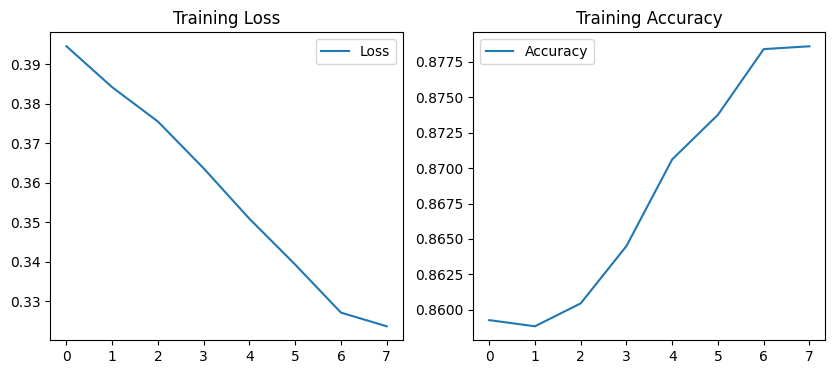

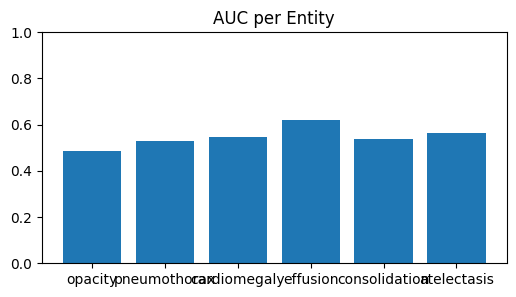

In [ ]:
# Loss & accuracy curves
plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.plot(losses,label="Loss"); plt.title("Training Loss"); plt.legend()
plt.subplot(1,2,2); plt.plot(accs,label="Accuracy"); plt.title("Training Accuracy"); plt.legend()
plt.show()

# AUC bar chart
plt.figure(figsize=(6,3))
plt.bar(list(aucs.keys()), [v for v in aucs.values()])
plt.ylim(0,1); plt.title("AUC per Entity"); plt.show()